In [52]:
#Module 1 
from pathlib import Path
import os
import random
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

DATA_DIR = Path(r'D:\datasets')  # <-- CHANGE THIS

CLASSES = ["puffy eyes", "wrinkles", "dark spots", "clear skin"]


In [3]:
#Image count per class
counts = {}

for cls in CLASSES:
    folder = DATA_DIR / cls
    counts[cls] = len(list(folder.glob("*.*")))

counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=["count"])
counts_df


,count
puffy eyes,219
wrinkles,245
dark spots,264
clear skin,180


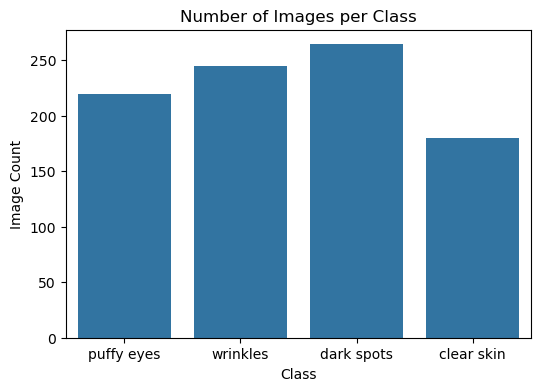

In [4]:
plt.figure(figsize=(6,4))
sns.barplot(x=counts_df.index, y=counts_df['count'])
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.show()


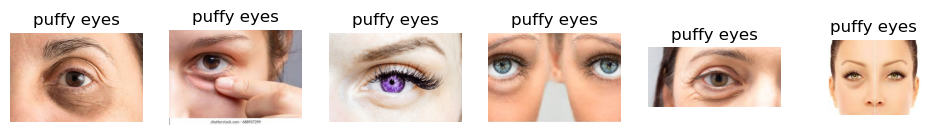

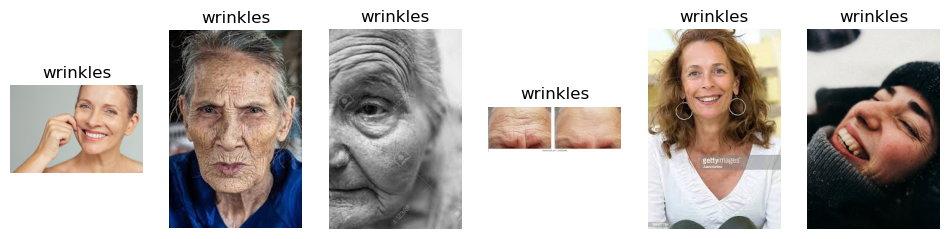

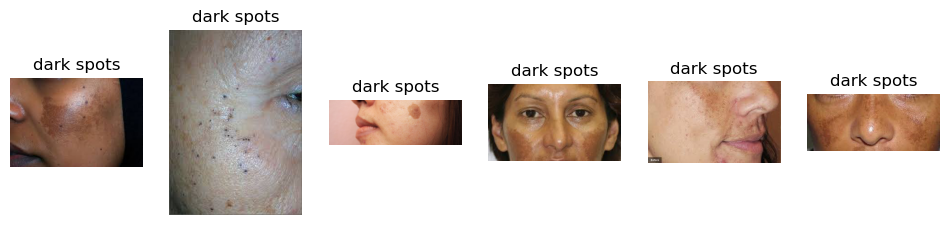

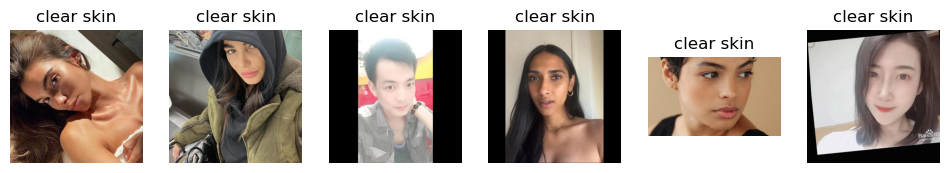

In [19]:
#Sample image grids
def show_samples(cls, n=6):
    folder = DATA_DIR / cls
    paths = list(folder.glob("*.*"))
    sample = random.sample(paths, min(n, len(paths)))

    plt.figure(figsize=(12,3))
    for i, img_path in enumerate(sample, 1):
        img = Image.open(img_path)
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
    plt.show()

for cls in CLASSES:
    show_samples(cls)


In [20]:
#Image size distribution
widths = []
heights = []
labels = []

for cls in CLASSES:
    for path in (DATA_DIR/cls).glob("*.*"):
        try:
            img = Image.open(path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            labels.append(cls)
        except:
            pass

df_sizes = pd.DataFrame({
    "class": labels,
    "width": widths,
    "height": heights
})


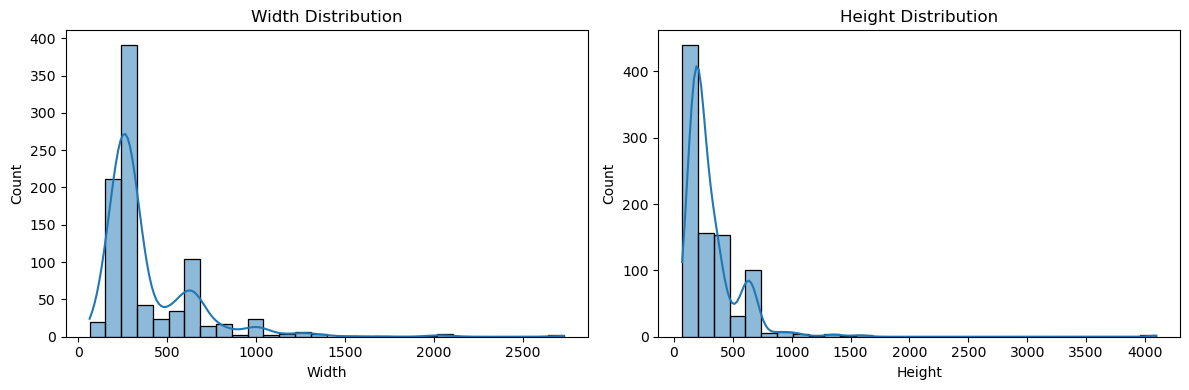

In [22]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df_sizes["width"], kde=True, bins=30)
plt.title("Width Distribution")
plt.xlabel("Width")

plt.subplot(1,2,2)
sns.histplot(df_sizes["height"], kde=True, bins=30)
plt.title("Height Distribution")
plt.xlabel("Height")

plt.tight_layout()
plt.show()


In [23]:
#Brightness distribution
brightness_vals = []
brightness_classes = []

for cls in CLASSES:
    for path in (DATA_DIR/cls).glob("*.*"):
        try:
            img = Image.open(path).convert("L")
            brightness_vals.append(ImageStat.Stat(img).mean[0])  # 0–255
            brightness_classes.append(cls)
        except:
            pass

df_brightness = pd.DataFrame({
    "class": brightness_classes,
    "brightness": brightness_vals
})


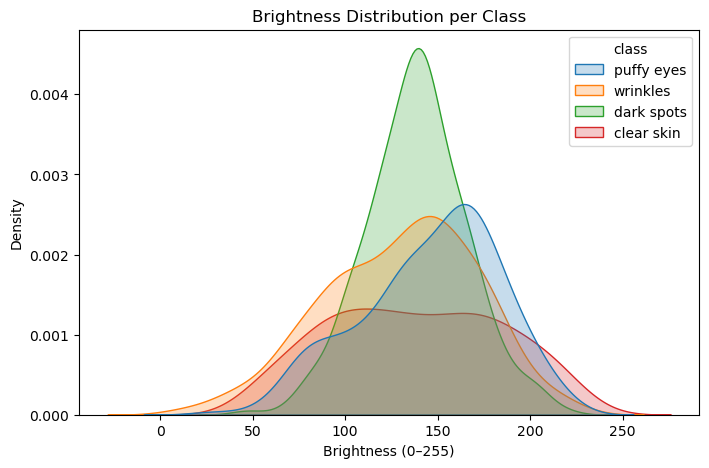

In [24]:
#KDE Plot 
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_brightness, x="brightness", hue="class", fill=True)
plt.title("Brightness Distribution per Class")
plt.xlabel("Brightness (0–255)")
plt.show()


In [25]:
bad_files = []

for cls in CLASSES:
    for p in (DATA_DIR/cls).glob("*.*"):
        try:
            Image.open(p)
        except:
            bad_files.append(p)

print("Corrupt files:", len(bad_files))


Corrupt files: 0


In [41]:
#Module 2
#Preprocess Images (Resize + Normalize)
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random


In [42]:
from pathlib import Path
import numpy as np
from PIL import Image
import tensorflow as tf

DATA_DIR = Path(r'D:\datasets')
CLASSES = ["puffy eyes", "wrinkles", "dark spots", "clear skin"]
IMG_SIZE = (224, 224)

X = []
y = []
OUTPUT_DIR = Path(r'D:\processed')

# Create folder if it doesn't exist
OUTPUT_DIR.mkdir(exist_ok=True)
print("Saving outputs to:", OUTPUT_DIR)



Saving outputs to: D:\processed


In [43]:
for cls in CLASSES:
    folder = DATA_DIR / cls
    label_idx = CLASSES.index(cls)

    for img_path in folder.glob("*.*"):
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)
            img = np.array(img) / 255.0   # NORMALIZATION
            X.append(img)
            y.append(label_idx)
        except:
            pass


In [44]:
X = np.array(X)
y = tf.keras.utils.to_categorical(y, num_classes=len(CLASSES))

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (908, 224, 224, 3)
y shape: (908, 4)


In [49]:
np.save(OUTPUT_DIR / "X_encoded.npy", X)
np.save(OUTPUT_DIR / "y_encoded.npy", y)

print("Saved preprocessed files to:", OUTPUT_DIR)


Saved preprocessed files to: D:\processed


In [46]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)


In [47]:
augmented_images = []
augmented_labels = []

batch_size = 32
aug_iter = datagen.flow(X, y, batch_size=batch_size)

num_batches = int(len(X) / batch_size)

for _ in range(num_batches):
    batch_x, batch_y = next(aug_iter)
    augmented_images.append(batch_x)
    augmented_labels.append(batch_y)

X_aug = np.concatenate(augmented_images)
y_aug = np.concatenate(augmented_labels)


In [48]:
np.save(OUTPUT_DIR / "X_augmented.npy", X_aug)
np.save(OUTPUT_DIR / "y_augmented.npy", y_aug)

print("Saved augmented files to:", OUTPUT_DIR)


Saved augmented files to: D:\processed


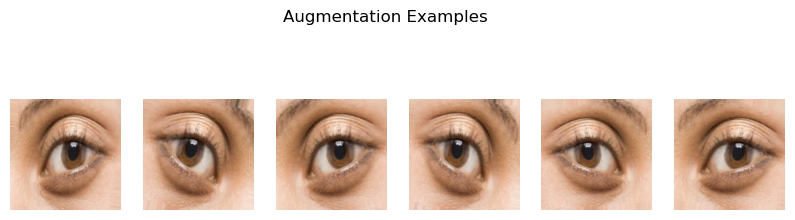

In [50]:
#Generate augmented samples for visualization
sample_img = X[0].reshape(1, 224, 224, 3)

aug_iter = datagen.flow(sample_img, batch_size=1)

plt.figure(figsize=(10,3))
for i in range(6):
    aug_img = next(aug_iter)[0]
    plt.subplot(1,6,i+1)
    plt.imshow(aug_img)
    plt.axis("off")
plt.suptitle("Augmentation Examples")
plt.show()


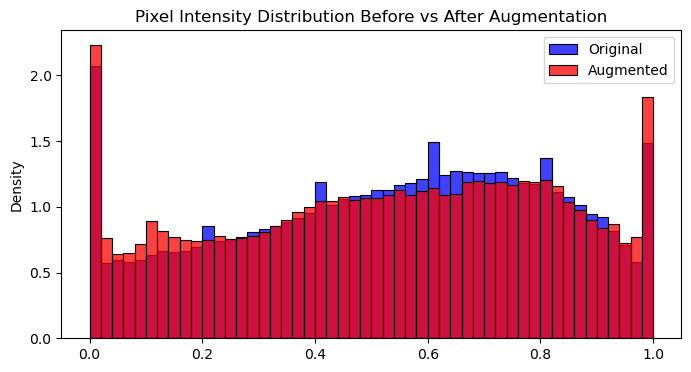

In [51]:
#Augmentation Quality Visualization
plt.figure(figsize=(8,4))
sns.histplot(X.ravel(), bins=50, color="blue", label="Original", stat="density")

aug_batch = datagen.flow(X, y, batch_size=100)
augmented_sample, _ = next(aug_batch)

sns.histplot(augmented_sample.ravel(), bins=50, color="red", label="Augmented", stat="density")

plt.legend()
plt.title("Pixel Intensity Distribution Before vs After Augmentation")
plt.show()


In [53]:
X_final = np.load(r'D:\processed\X_augmented.npy')
y_final = np.load(r'D:\processed\y_augmented.npy')


In [54]:
from sklearn.model_selection import train_test_split
import numpy as np


In [55]:
# First split: training (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y_final, test_size=0.20, random_state=42, stratify=y_final
)

# Second split: validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (716, 224, 224, 3) (716, 4)
Validation: (90, 224, 224, 3) (90, 4)
Test: (90, 224, 224, 3) (90, 4)


In [56]:
OUTPUT_DIR = Path(r'D:\processed')

np.save(OUTPUT_DIR / "X_train.npy", X_train)
np.save(OUTPUT_DIR / "y_train.npy", y_train)

np.save(OUTPUT_DIR / "X_val.npy", X_val)
np.save(OUTPUT_DIR / "y_val.npy", y_val)

np.save(OUTPUT_DIR / "X_test.npy", X_test)
np.save(OUTPUT_DIR / "y_test.npy", y_test)

print("Saved all dataset splits successfully!")


Saved all dataset splits successfully!
